# MC Dropout as Bayesian Approximation Notebook

Goal: A complete workflow with prototypical functions that I'll be using for all the other workflows.

Some of the workflow will be taken from my code from Statistical NLP module.
* Ideally it's not too difficult to swap things like the dropout regime, training schedule etc
* Need to have a training manager that saves and logs data
* Better way to define UNet - also possibly easy to switch out other networks would be nice

10th June: Complete notebook sketch

# Installs & Imports

In [ ]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.9 MB/s eta 0:00:00


In [ ]:
import os
import copy
import random
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchmetrics

from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary
from tqdm.notebook import tqdm
from datetime import date

# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


## Import dataset

Currently I import from google drive to keep the flexibility of able to import eval set here as well.
If I just need training set we could use git clone to get the zip file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

# copy dataset to local env
if 'mastr' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
  !unzip -q 'mastr.zip' -d mastr
  !rm 'mastr.zip'

# copy test set to local env
if 'mods' not in os.listdir():
  !cp "/content/drive/MyDrive/ShorelineNet_pytorch/dataset/mods_small.zip" .
  !unzip -q 'mods_small.zip' -d mods
  !rm 'mods_small.zip'


Mounted at /content/drive/


# Process Data

### Define some global variables

In [ ]:
# Global variables
CLASS_MAP_ALL = {0: 'obstacle', 1: 'water', 2: 'sky', 3: 'ambiguous', 4: 'remove'} # 3 and 4 should not be fed into the network
CLASS_MAP = {0: 'obstacle', 1: 'water', 2: 'sky'} # only valid classes
NUM_CLASSES = len(CLASS_MAP.keys())
SEED = 0

# dummy pixel (placed at boundaries), we want to change it from 4 to 3, then drop it in the end
DROP_PIX = 4
FILL_PIX = 3

TRAINING_PATH = '/content/mastr/'
IMAGE_DIR = TRAINING_PATH + 'images/'
LABEL_DIR = TRAINING_PATH + 'masks/'

# TODO: change
# TESTING_PATH = '/content/mods/sequences/'
TESTING_PATH = '/content/mods/mods_small/sequences/'

## Train-val split

In [ ]:
def train_val_test_split(X, y, train_ratio, val_ratio):
  '''
  splits the dataset into train and validation sets
  '''
  torch.manual_seed(SEED) # !important

  n = X.shape[0]

  perm = torch.randperm(n)

  tr_ratio = train_ratio / (train_ratio+val_ratio)
  v_ratio = val_ratio / (train_ratio+val_ratio)

  tr_n = int(tr_ratio * n)
  val_n = int(v_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:]], y[perm[tr_n:]]

  return X_train, y_train, X_val, y_val

## Transformation
All the transformations are performed using `torchvision.transforms` or `transforms.functional`.
* `HFlip`: Horizontal flip
* `HueSatCon`: Brightness, contrast, saturation, and hue (always applied)
* `Affine`: Translation and Shear
* `Rotation`: Rotate
* `Crop`
* `Resize`

The transformations should be performed in the order above, the goal is to emulate scenes similar to shoreline images, thus ordering matters. E.g. Horizontal shear followed by rotate is preferred compared to the other way around.

In [ ]:
# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

# Only on tensors!
class HFlip(object):
    def __init__(self, prob=0.5):
        self.flip_transform = transforms.RandomHorizontalFlip(1)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          x = self.flip_transform(x)
          y = self.flip_transform(y)

        return (x, y)

class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob=1):
        self.hue_transform = transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob and x!= None:
            x = self.hue_transform(x)
        return (x, y)

class Rotation(object):
    def __init__(self, angle, prob=1):
        self.angle = angle
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # comptute random angle to rotate for this instance
          rot_angle = (random.random()*2-1) * self.angle
          x = transforms.functional.rotate(x, rot_angle, expand=False)
          y = transforms.functional.rotate(y, rot_angle, expand=False, fill=FILL_PIX)
        return (x, y)

class Crop(object):
    def __init__(self, crop_percentage, prob=1):
        self.crop_percentage = crop_percentage
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # compute random crop proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length
          # percentage crop in the horizontal direction
          crop1 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # percentage crop in the vertical direction
          crop2 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # compute all the arguments for TF.crop()
          width = int(crop1 * dim1)
          height = int(crop2 * dim2)
          left = int(random.random() * ((1-crop1)/2) * dim1)
          top = int(random.random() * ((1-crop2)/2) * dim2)

          x = transforms.functional.crop(x, top, left, height, width)
          y = transforms.functional.crop(y, top, left, height, width)

        return (x, y)

# Translation and Shear
class Affine(object):
    def __init__(self, affine_percentage, shear_deg, prob=1):
        self.affine_percentage = affine_percentage # (e.g. 0.1)
        self.shear_deg = shear_deg # in deg (e.g. 15)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data

        p = random.random()
        if p < self.prob:
          # compute random affine proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length

          # translation offset for this instance
          offset1 = (random.random() * 2 - 1) * dim1 * self.affine_percentage
          offset2 = (random.random() * 2 - 1) * dim2 * self.affine_percentage
          # shear deg for this instance
          shear = (random.random() * 2 - 1) * self.shear_deg

          # apply affine transformation
          x = torchvision.transforms.functional.affine(x, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.BILINEAR)
          y = torchvision.transforms.functional.affine(y, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.NEAREST, fill=FILL_PIX)
        return (x, y)

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)
        self.resize_y = transforms.Resize(size, transforms.InterpolationMode.NEAREST, antialias=True) #nearest-exact?

    def __call__(self, data):
        x, y = data
        x = self.resize_x(x)
        y = self.resize_y(y)

        return (x, y)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, move_to_device=True):
        self.to_tensor = transforms.PILToTensor()
        self.move = move_to_device

    def __call__(self, data):
        x, y = data

        x = self.to_tensor(x)
        y = self.to_tensor(y)

        if self.move:
          x = x.to(DEVICE)
          y = y.to(DEVICE)

        # Normalize - TODO
        # x = x / 255.0

        imageNet_normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        x = imageNet_normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

class Normalize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, data):
        x, y = data
        x = self.Normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

### Test set transformations

Only operates on x (images) and there are no y (labels).

In [ ]:
# transformations for test set:

class Normalize_test(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, x):
        x = self.Normalize(x)
        return x

class Resize_test(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)

    def __call__(self, x):
        x = self.resize_x(x)
        return x


### Unnormalize

In [ ]:
def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

## Dataset Definition

Two definitions for dataset:
* `OnlineDataset` doesn't store the processed images and reads them from the drive's local folder, used for evaluation dataset
* `MemoryDataset` loads all the images into memory. This only works for the training set which is relatively small.

In [ ]:
class OnlineDataset(Dataset):
    def __init__(self, x_dir, y_dir, transform=None):
        '''
        Online dataset that takes directories as inputs and loads the images

        Args
        ------
        x_dir : str, directory holding images (e.g. /content/mastr/images)
        y_dir : str, directory holding labels (e.g. /content/mastr/masks)
        transforms : transforms.Compose([...])
        '''
        self.y_dir = y_dir
        self.x_dir = x_dir
        self.transform = transform

        # This list is used to index all the images in the directory
        # image and labels share same prefix in the names
        self.x_file_names = os.listdir(x_dir)

    def __len__(self):
        return len(os.listdir(self.x_dir))

    def __getitem__(self, idx):
        # get image and label path
        x_path = os.path.join(self.x_dir, self.x_file_names[idx])
        # TODO: can refactor this if other dataset are used
        y_path = os.path.join(
            self.y_dir, self.x_file_names[idx].replace(".jpg", "m.png"))

        x = read_image(x_path)
        y = read_image(y_path)

        # NOTE: image format(C, W, H)

        if self.transform:
            x, y = self.transform((x, y))

        return x, y

class MemoryDataset(Dataset):
    def __init__(self, X, y, transform=None):
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, 384, 512)
        y : Tensor with shape (n, 1, 384, 512)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            x, y = self.transform((x, y))
        return x, y

class EvaluationDataset(Dataset):
  def __init__(self, transforms=None, eval_dir=TESTING_PATH):
    self.image_paths = []
    self.out_paths = []
    self.transforms = transforms
    for sequence in os.listdir(eval_dir):
      for img in os.listdir(os.path.join(eval_dir, sequence, 'frames')):
        self.image_paths.append(os.path.join(eval_dir, sequence, 'frames', img))
        self.out_paths.append(os.path.join(sequence, img))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    x = read_image(img_path)
    x = x.to(DEVICE)
    x = x/255.0
    if self.transforms:
      x = self.transforms(x)
    return x, self.out_paths[idx]



## Load training set
Load entire training set MaSTr1325 into memory and create dataset objects

In [ ]:
# load all of training data into memory
def load_mastr(img_dir, mask_dir):
    '''Load all data into memory '''
    img_file_names = os.listdir(img_dir)
    n = len(img_file_names)
    # preallocate tensor memory
    X = torch.zeros((n, 3, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)

    for i in tqdm(range(n)):
      img_path = os.path.join(img_dir, img_file_names[i])
      mask_path = os.path.join(
          mask_dir, img_file_names[i].replace(".jpg", "m.png"))

      x = read_image(img_path)
      y = read_image(mask_path)

      x = x / 255.0
      y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return X, Y

In [ ]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = None, None, None, None
X_raw, y_raw = load_mastr(IMAGE_DIR, LABEL_DIR)
print(f'Number of total images: {len(X_raw)}')

  0%|          | 0/1325 [00:00<?, ?it/s]

Number of total images: 1325


## Split dataset

Number of training images: 1225
Number of validation images: 100


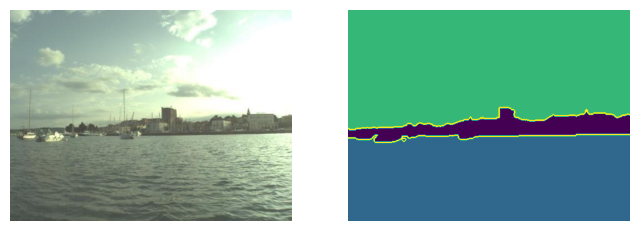

In [ ]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = train_val_test_split(X_raw, y_raw, 1225, 100)
print(f'Number of training images: {len(X_train_raw)}')
print(f'Number of validation images: {len(X_val_raw)}')

# show sample image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')

del X_raw, y_raw

## Dataset Manager



In [ ]:
class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, X_train_raw, y_train_raw, X_val_raw, y_val_raw):
    self.X_train_raw = X_train_raw
    self.y_train_raw = y_train_raw
    self.X_val_raw = X_val_raw
    self.y_val_raw = y_val_raw

    train_transforms = self._get_train_transforms(intensity=1)

    val_transforms = transforms.Compose([
        Resize((224, 224)),
        Normalize(),
    ])

    test_transforms = transforms.Compose([
        Resize_test((224, 224)),
        Normalize_test()
    ])

    train_dataset = MemoryDataset(X_train_raw, y_train_raw, train_transforms)
    val_dataset = MemoryDataset(X_val_raw, y_val_raw, val_transforms)
    test_dataset = EvaluationDataset(test_transforms)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

  def _get_train_transforms(self, intensity=1):
    z = intensity
    train_transforms = transforms.Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.1*z, contrast=0.1*z, saturation=0.1*z, hue=0.1*z, prob=1),
      Affine(affine_percentage=0.1*z, shear_deg=5*z, prob=1),
      Rotation(10*z, prob=1),
      Crop(crop_percentage=1-z*0.1, prob=1),
      Resize((224, 224)),
      Normalize(),
    ])
    return train_transforms

  def update_train_transforms(self, intensity=1):
    train_transforms = self._get_train_transforms(intensity)
    self.datasets['train'] = MemoryDataset(X_train_raw, y_train_raw, train_transforms)
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return

dataset_manager = DatasetManager(X_train_raw, y_train_raw, X_val_raw, y_val_raw)

## Preview Dataloaders

Note that during training, dataloaders are generated within each training manager (since initializing dataloaders are cheap).

In [ ]:
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=False)

# global dataloader that isn't actually used for training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

### Example images

These are images that will be fed into the network

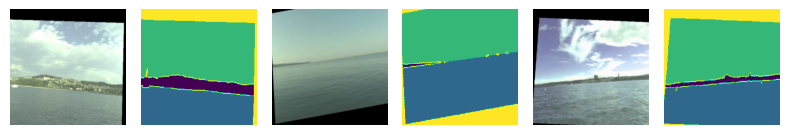

In [ ]:
x_batch_sample, y_batch_sample = next(iter(train_dataloader))

plt.figure(figsize=(8, 3))
for i in range(3):
  plt.subplot(1, 6, i*2+1)
  plt.imshow(unnormalize(x_batch_sample[i]).permute(1, 2, 0).cpu())
  plt.axis('off')
  plt.subplot(1, 6, i*2+2)
  plt.imshow(y_batch_sample[i].permute(1, 2, 0).cpu())
  plt.axis('off')

# note: clipping error message can be ignored
plt.tight_layout()


# # VALIDATION IMAGES
# plt.figure(figsize=(8, 3))
# for i in range(3):
#   x, y = next(iter(val_dataloader))
#   plt.subplot(1, 6, i*2+1)
#   x = unnormalize(x[0])
#   plt.imshow(x.permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.subplot(1, 6, i*2+2)
#   plt.imshow(y[0].permute(1, 2, 0).cpu())
#   plt.axis('off')

# plt.tight_layout()

# TESTING IMAGES
# plt.figure(figsize=(8, 3))
# i = 0
# for x, filepath in test_dataloader:
#   if i == 6:
#     break
#   plt.subplot(1, 6, i+1)
#   x = unnormalize(x[0])
#   plt.imshow(x.permute(1, 2, 0).cpu())
#   plt.axis('off')
#   i += 1
# plt.tight_layout()


# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## UNet

In [ ]:
class Unet_MobileNetV2(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # attaches hooks to the encoder
        # self.feature_extractor = Encoder_feature_extractor(self.encoder)

        # dummy forward pass to load decoder
        dummy_input = torch.rand((2, 3, 224, 224))
        self.decoder.load(self.encoder(dummy_input))

        assert(self.decoder.loaded==True)

        # freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out

    def set_encoder_grad(self, requires_grad):
        for param in self.encoder.parameters():
            param.requires_grad = requires_grad

    def toggle_dropout(self, dropout_state):
        self.encoder.toggle_dropout(dropout_state)
        self.decoder.toggle_dropout(dropout_state)

    def update_dropout_config(self, encoder_config, decoder_config):
        self.encoder.update_dropout_config(encoder_config)
        self.decoder.update_dropout_config(decoder_config)


### Encoder

In [ ]:
class Unet_MobileNetV2_Encoder(nn.Module):
    def __init__(self, pretrained_net, dropout_config=[]):
        '''
        Args
        ---------
        pretrained_net: nn.Module, pretrained mobileNet
        dropout_config: list
        '''
        super().__init__()
        self.net = copy.deepcopy(pretrained_net)

        self.dropout_state = True
        if dropout_config == []:
          self.dropout_config = [0, 0, 0, 0.5, 0.5]
        else:
          self.dropout_config = dropout_config

        # attach dropout layers to the features
        for i, n in enumerate([2, 4, 7, 14]):
            old_conv = self.net.features[n].conv[0]
            p = self.dropout_config[i]
            self.net.features[n].conv[0] = nn.Sequential(
                old_conv,
                nn.Dropout(p)
            )

        old_conv = self.net.features[17]
        self.net.features[17] = nn.Sequential(
            old_conv,
            nn.Dropout(p=self.dropout_config[-1])
        )

        # point to dropout layers
        self.dropout_layers = [
            self.net.features[2].conv[0][-1],
            self.net.features[4].conv[0][-1],
            self.net.features[7].conv[0][-1],
            self.net.features[14].conv[0][-1],
            self.net.features[17][-1],
        ]

        self._load()

    def _load(self):
        '''
        Attaches feature extractor to the encoder
        '''
        self.feature_extractor = Encoder_feature_extractor(self.net)

    def toggle_dropout(self, dropout_state):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config):
        self.dropout_config = dropout_config

    def forward(self, x):
        if self.dropout_state == True:
            for m in self.modules():
              if m.__class__.__name__.startswith('Dropout'):
                m.train()
            for i in range(len(self.dropout_layers)):
              self.dropout_layers[i].p = self.dropout_config[i]

        out = self.net(x)

        features = self.feature_extractor.features

        # if self.dropout_state == True:
        #   for k, v in features.items():
        #     d = nn.Dropout(p=self.dropout_config[k])
        #     features[k] = d(features[k])

        return features

### Decoder

In [ ]:
# Conv2DTranspose => Batchnorm => Dropout => Relu
class Unet_MobileNetV2_Decoder(nn.Module):
    def __init__(self, dropout_config=None):
        super().__init__()
        self.loaded = False
        if dropout_config is None:
          dropout_config = [0.5, 0.5, 0.5, 0.5]

        self.dropout_state = True
        self.dropout_config = dropout_config

    def load(self, encoder_features):
        '''
        initiates the decoder layers based on encoder inputs
        '''
        # TODO (optional): refactor the decoder blocks for arbitrary encoder features

        deconv_outputs = [512, 256, 128, 64, 3]
        # print(encoder_features.features)

        in_channels = encoder_features['skip_5'].shape[1]

        self.block_1 = self.deconv_block(in_channels, deconv_outputs[0], 3, 2, self.dropout_config[0])
        in_channels = deconv_outputs[0] + encoder_features['skip_4'].shape[1]

        self.block_2 = self.deconv_block(in_channels, deconv_outputs[1], 3, 2, self.dropout_config[1])
        in_channels = deconv_outputs[1] + encoder_features['skip_3'].shape[1]

        self.block_3 = self.deconv_block(in_channels, deconv_outputs[2], 3, 2, self.dropout_config[2])
        in_channels = deconv_outputs[2] + encoder_features['skip_2'].shape[1]

        self.block_4 = self.deconv_block(in_channels, deconv_outputs[3], 3, 2, self.dropout_config[3])
        in_channels = deconv_outputs[3] + encoder_features['skip_1'].shape[1]

        self.final_layer = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.softmax = nn.LogSoftmax(dim=1)

        self.loaded = True

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        conv_transpose_2d = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        torch.nn.init.xavier_normal_(conv_transpose_2d.weight)
        return nn.Sequential(
            conv_transpose_2d,
            nn.BatchNorm2d(num_features=out_channels),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )

    def toggle_dropout(self, dropout_state: bool):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config: list):
        self.dropout_config = dropout_config

    def forward(self, input):
        assert(self.loaded==True)

        # overwrite unet train/eval state for the dropout layers
        if self.dropout_state == True:
          for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
              m.train()
          self.block_1[2].p = self.dropout_config[0]
          self.block_2[2].p = self.dropout_config[1]
          self.block_3[2].p = self.dropout_config[2]
          self.block_4[2].p = self.dropout_config[3]

        x = input['skip_5']
        x = self.block_1(x)
        x = torch.cat((x, input['skip_4']), dim=1)
        x = self.block_2(x)
        x = torch.cat((x, input['skip_3']), dim=1)
        x = self.block_3(x)
        x = torch.cat((x, input['skip_2']), dim=1)
        x = self.block_4(x)
        x = torch.cat((x, input['skip_1']), dim=1)
        x = self.final_layer(x)
        x = self.softmax(x)

        return x

### Feature Extractor

In [ ]:
class Encoder_feature_extractor():
    def __init__(self, encoder):
        self.features = {}

        layers = {
            "skip_1": encoder.features[2].conv[0][-1],
            "skip_2": encoder.features[4].conv[0][-1],
            "skip_3": encoder.features[7].conv[0][-1],
            "skip_4": encoder.features[14].conv[0][-1],
            "skip_5": encoder.features[17]
        }

        for (name, layer) in layers.items():
            layer.register_forward_hook(self._get_feature(name))

    def _get_feature(self, name):
        def hook(model, input, output):
            self.features[name] = output
        return hook

### Initiate Network

Download pretrained mobileNet weights and remove last two layers

In [ ]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 77.7MB/s]


In [ ]:
# This is just to preview the network, usually the network is initiated within the training manager.
encoder = Unet_MobileNetV2_Encoder(mobileNet)
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

# move network to GPU
unet.to(DEVICE)
print(f'Network is on {next(unet.parameters()).device}')

Network is on cuda:0


In [ ]:
# Set dropout config
encoder_dropout_config = [0.0, 0.0, 0.0, 0.5, 0.5]
decoder_dropout_config = [0.5, 0, 0, 0]

unet.toggle_dropout(True)
unet.update_dropout_config(encoder_dropout_config, decoder_dropout_config)

### Dummy pass to see initial outputs

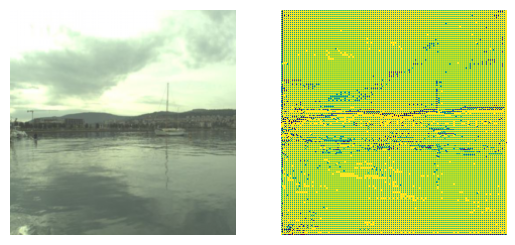

In [ ]:
x_batch_sample, y_batch_sample = next(iter(test_dataloader))

net = unet
# net = training_manager.net

with torch.no_grad():
  net.eval()
  plt.subplot(1, 2, 1)
  plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
  plt.axis('off')

  pred = net(x_batch_sample.to(DEVICE))
  plt.subplot(1, 2, 2)
  plt.imshow(torch.argmax(pred[0], dim=0).cpu().detach().numpy())
  plt.axis('off')
  net.train()

## Loss

In [ ]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 3, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / mask.sum()

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 3, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [ ]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [ ]:
class AccuracyMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=3, average='none', ignore_index=3).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, 3, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [ ]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=3, average='none', ignore_index=3).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, 3, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

In [ ]:
# temp_metric = IOUMetric()

# x_batch_sample, y_batch_sample = next(iter(val_dataloader))
# print(x_batch_sample.shape)
# net = training_manager.best_net

# with torch.no_grad():
#   net.eval()
#   pred = net(x_batch_sample.to(DEVICE))
#   print(pred.shape)
#   # print(temp_metric(y_batch_sample.to(int).squeeze(dim=1).cpu(), pred.cpu()))

# plt.imshow(pred[0].cpu().argmax(dim=0))

# Bayesian Functions

## Bayes forward pass

In [ ]:
def bayes_forward(net, X:torch.tensor, k:int, buffer=None):
  '''
  Performs k forward passes with dropout layers, returns mean and std

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (3 x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x 3 x 224 x 224) buffer

  Returns
  -----------
  y_softmax            : torch.tensor (3 x 224 x 224)
  y_pred               : torch.tensor (224 x 224)
  y_pred_std_per_class : torch.tensor (3 x 224 x 224)
  y_pred_std_avg       : torch.tensor (224 x 224)
  '''
  if buffer is None:
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
  else:
    for i in range(k):
      # write image to buffer
      buffer[i] = X

  with torch.no_grad():
      net.eval()
      net.toggle_dropout(True)
      y_pred_raw = net(buffer)

  net.train()

  # Average the softmax (note that the resultant vectors are not normalised)
  y_softmax = y_pred_raw.mean(dim=0) # (3 x 224 x 224)
  # Take max prob as prediction
  y_pred = torch.argmax(y_softmax, dim=0).to(torch.int) # (224 x 224)
  # Per class uncertainty
  y_pred_std_per_class = y_pred_raw.exp().var(dim=0) # (3 x 224 x 224)
  # Average uncertainty over classes
  y_pred_std_avg = y_pred_std_per_class.mean(dim=0) # (224 x 224)

  return y_softmax, y_pred, y_pred_std_per_class, y_pred_std_avg

## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

In [ ]:
def bayes_eval(net, X:torch.tensor, k:int, buffer=None):
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (3 x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x 3 x 224 x 224) buffer

  Returns
  -----------
  y_pred               : torch.tensor (224 x 224)
  '''

  with torch.no_grad():
    net.eval()
    if k == 0:
      net.toggle_dropout(False)
      y_pred_raw = net(X)
    elif k > 0:
      net.toggle_dropout(True)
      # write image to buffer
      if buffer is None:
        buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
      else:
        for i in range(k):
          buffer[i] = X
      y_pred_raw = net(buffer)
      # y_pred_raw = torch.rand((k, 3, 224, 224))

  y_pred = torch.argmax(y_pred_raw.mean(dim=0), dim=0).to(torch.int8) # (224 x 224)

  return y_pred

## Calibration

In [ ]:
def plot_calibration(net, dataloader, ks=[0, 5, 10], num_buckets = 10):
  x_axis = np.array(range(num_buckets)) / num_buckets
  linear_line = np.array(range(num_buckets+1)) / (num_buckets+1)

  plt.figure(figsize=(8, 6))
  plt.plot(linear_line, linear_line, color='black', zorder=2)
  for i, k in enumerate(ks):
    buckets = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)
    # plt.subplot(1, 3, i+1)
    # plt.bar(x_axis, buckets, width=0.5, align='edge')
    plt.plot(x_axis, buckets, label=f'k={k}')
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  plt.legend()


def get_calibration(net, dataloader, k:int, num_buckets=10):
  '''
  Plots reliability graph for the network

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  '''
  total_counts = np.array([1e-16]*num_buckets)
  total_corrects = np.array([0]*num_buckets)

  # loop through images and make predictions
  for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.toggle_dropout(False)
          y_softmax = net(x.unsqueeze(dim=0)).squeeze(dim=0)
        elif k > 0:
          net.toggle_dropout(True)
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        y_softmax = torch.softmax(y_softmax, dim=0)

        counts, corrects =  get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects
      #   count += 1
      # if count == 10:
      #   break

  buckets = total_corrects / total_counts

  return buckets

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x 224 x 224)
  y_softmax: torch.tensor (3 x 224 x 224)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, )
  correct: np.array (num_buckets, )
  '''
  out_count = np.array([0]*num_buckets)
  out_correct = np.array([0]*num_buckets)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    out_count[i] += ((indices==i)).sum()
    out_correct[i] += ((indices==i)*(y_pred==y_gt)).sum()

  return out_count, out_correct


## Epistemic & Aleatoric Uncertainties

In [ ]:
def compute_bayesian_uncertainties(net, X:torch.tensor, k:int,) -> (torch.tensor, torch.tensor):
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (3 x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x 3 x 224 x 224) buffer

  Returns
  -----------
  aleatoric_uncertainty: torch.tensor (224 x 224)
  epistemic_uncertainty: torch.tensor (224 x 224)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.toggle_dropout(True)
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X
    y_pred_raw = net(buffer).softmax(dim=1)

    avg_over_k = y_pred_raw.mean(dim=0)
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k)).sum(dim=0)
    mutual_information = predictive_entropy + 1/k * (y_pred_raw*torch.log(y_pred_raw)).sum(dim=0).sum(dim=0)

  epistemic_uncertainty = mutual_information
  aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

  return aleatoric_uncertainty, epistemic_uncertainty

In [ ]:
# aleatoric, epistemic = compute_bayesian_uncertainties(exp.net, x, k)

# print(aleatoric)
# plt.imshow(aleatoric.cpu())

## PAvPU metric

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [ ]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.encoder_dropout_config = self.config['encoder_dropout_config']
    self.decoder_dropout_config = self.config['decoder_dropout_config']
    self.patience = self.config.get('patience', 20)

    # initiate dataloader
    train_dataloader = DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True)
    val_dataloader = DataLoader(self.datasets['val'], batch_size=1, shuffle=True)
    test_dataloader = DataLoader(self.datasets['test'], batch_size=1, shuffle=False)
    self.dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

    # initiate net
    encoder = Unet_MobileNetV2_Encoder(copy.deepcopy(mobileNet)) # global variable
    decoder = Unet_MobileNetV2_Decoder(decoder_dropout_config)

    self.net = Unet_MobileNetV2(encoder, decoder).to(DEVICE)
    self.best_net = None

    # dropout parameters
    self.net.toggle_dropout(True)
    self.net.update_dropout_config(encoder_dropout_config, decoder_dropout_config)

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.epoch = 0
    self.early_stop = False
    self.history = {
        'loss/train': [],
        'loss/val': [],
        'loss/val_b': [],
        # 'loss/test': [],
        'acc/avg/train': [],
        'acc/avg/val': [],
        'acc/avg/val_b': [],
        # 'acc/avg/test': [],
        'acc/global/train': [],
        'acc/global/val': [],
        'acc/global/val_b': [],
        'iou/mean/train': [],
        'iou/mean/val': [],
        'iou/mean/val_b': [],
        # 'acc/global/test': [],
    }

    for c in CLASS_MAP.values():
      self.history[f'acc/{c}/val'] = []
      self.history[f'acc/{c}/val_b'] = []
      self.history[f'iou/{c}/val'] = []
      self.history[f'iou/{c}/val_b'] = []
      # self.history[f'acc/{c}/test'] = []

    self.history['best_val_loss'] = 999
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    self.net.toggle_dropout(True)

    for e in range(epochs):
      train_loss_epoch = 0
      train_global_acc_epoch = 0
      train_avg_acc_epoch = 0
      train_mIOU_epoch = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_pred = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_pred)
        accs = self.metric(y_batch, y_pred)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_loss_epoch += loss * batch_size
        train_global_acc_epoch += accs['acc/global'] * batch_size
        train_avg_acc_epoch += accs['acc/avg'] * batch_size
        train_mIOU_epoch += accs['iou/mean'] * batch_size

      # log epoch loss and accuracy
      n_train = len(self.dataloaders['train'].dataset)
      self.history['loss/train'].append(train_loss_epoch.item()/n_train)
      self.history['acc/global/train'].append(train_global_acc_epoch.item()/n_train)
      self.history['acc/avg/train'].append(train_avg_acc_epoch.item()/n_train)
      self.history['iou/mean/train'].append(train_avg_acc_epoch.item()/n_train)

      # run network on validation set
      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode)
      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

      self._update_best_net()
      if self.early_stop:
        return

  def _update_best_net(self, min_epochs = 10):
    metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history[metric]) <= 1:
      return

    loss = self.history[metric][-1]
    curr_min = self.history['best_val_loss']

    if loss < curr_min:
      print(f'updating best net, loss decreased by {(curr_min-loss)/curr_min*100 :.3f} %')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_val_loss'] = loss
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0
    else:
      self.patience_count += 1
    if self.patience_count == self.patience:
      print(f'{metric} has not improved for {self.patience} epochs, terminate training')
      self.early_stop = True

  def _evaluate_regular(self, dataloader, net=None):
    net = net if net != None else self.net
    net.eval()
    net.toggle_dropout(False)
    total_loss = 0
    total_accs = {}
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)
        total_loss += loss * len(X)

        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc * len(X)

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    buffer_tensor = torch.empty(size=(k, 3, 224, 224), dtype=torch.float32, device=DEVICE)

    net.toggle_dropout(True)
    net.update_dropout_config(self.encoder_dropout_config,
                                   self.decoder_dropout_config)

    total_loss = 0
    total_accs = {}
    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_pred, _, _, _ = bayes_forward(net, x, k, buffer_tensor)
        y_pred = y_pred.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)

        total_loss += loss
        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def evaluate(self, eval_dataset='val', mode='bayes'):
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(self.dataloaders[eval_dataset])
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(self.dataloaders[eval_dataset])
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(self.dataloaders[eval_dataset])
      loss_b, accs_b = self._evaluate_bayes(self.dataloaders[eval_dataset])
    else:
      return

    return loss, accs, loss_b, accs_b

  def plot(self, save=False, directory=None):
    '''
    Plots training history
    '''
    plt.figure(figsize=(16, 16))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.epoch+1, 1))
    plt.subplot(3, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(3, 3, 2)
    plt.title('Accuracy(g)')
    plt.plot(x, history['acc/global/train'], label='train',)
    plt.plot(x, history['acc/global/val'], label='val')
    plt.plot(x, history['acc/global/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    # plt.subplot(3, 3, 3)
    # plt.title('Accuracy(c)')
    # plt.plot(x, history['acc/avg/train'], label='train',)
    # plt.plot(x, history['acc/avg/val'], label='val')
    # plt.plot(x, history['acc/avg/val_b'], label='val_b')
    # plt.xlabel('epochs')
    # plt.ylabel('acc')
    # plt.legend()

    plt.subplot(3, 3, 3)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('iou')
    plt.legend()

    for i in range(3):
      plt.subplot(3, 3, 4+i)
      c_name = CLASS_MAP[i]
      plt.title(f'Accuracy({c_name})')
      # plt.plot(x, history[f'acc/{c_name}/train'], label='train',)
      plt.plot(x, history[f'acc/{c_name}/val'], label='val')
      plt.plot(x, history[f'acc/{c_name}/val_b'], label='val_b')
      plt.xlabel('epochs')
      plt.ylabel('acc')
      plt.legend()

    for i in range(3):
      plt.subplot(3, 3, 7+i)
      c_name = CLASS_MAP[i]
      plt.title(f'IOU({c_name})')
      plt.plot(x, history[f'iou/{c_name}/val'], label='val')
      plt.plot(x, history[f'iou/{c_name}/val_b'], label='val_b')
      plt.xlabel('epochs')
      plt.ylabel('iou')
      plt.legend()

    if save:
      plt.savefig(os.path.join(directory, 'history.png'), dpi=200)
    else:
      plt.show()

    return

  def plot_acc_vs_k(self, ks=[1, 3, 5, 10, 15, 20, 25, 30, 35, 40], dataloader=None, num_repeats=5, save_to_dir=None, net=None):
    '''
    plots accuracy vs k
    '''
    if dataloader is None:
      dataloader = self.dataloaders['val']

    # evaluate bayesian forward for different ks
    losses, accs_g, accs_a, mious = [], [], [], []
    losses_std, accs_g_std, accs_a_std, mious_std = [], [], [], []
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self._evaluate_regular(dataloader, net)

    for k in tqdm(ks):
      loss, acc_g, acc_a, miou = [], [], [], []
      for i in range(num_repeats):
        l, a = self._evaluate_bayes(dataloader, k, net)
        loss.append(l)
        acc_g.append(a['acc/global'])
        acc_a.append(a['acc/avg'])
        miou.append(a['iou/mean'])
      loss, acc_g, acc_a, miou = np.array(loss), np.array(acc_g), np.array(acc_a), np.array(miou)
      losses.append(loss.mean())
      losses_std.append(loss.std())
      accs_g.append(acc_g.mean())
      accs_g_std.append(acc_g.std())
      accs_a.append(acc_a.mean())
      accs_a_std.append(acc_a.std())
      mious.append(miou.mean())
      mious_std.append(miou.std())

      # print(f'{k}: {loss}, {accs['global']}, {accs['avg']}')


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, losses, yerr=losses_std, label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, accs_g, yerr=accs_g_std, label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, accs_a, yerr=accs_a_std, label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, mious, yerr=mious_std, label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    if save_to_dir != None:
      plt.savefig(os.path.join(save_to_dir, 'acc_v_k.png'), dpi=200)

    return

  def _save_model(self, directory, save_best):
    print(f'saving model at {self.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.net.state_dict(), os.path.join(directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.best_net != None:
      torch.save(self.best_net.state_dict(), os.path.join(directory, 'model_best.pt'))
    return

  def _save_history(self, directory):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    history['date'] = str(date.today())
    history['epoch'] = self.epoch
    filepath = os.path.join(directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f)
    return

  def _save_config(self, directory):
    print('saving config...')
    filepath = os.path.join(directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f)
    return

  def _save_summary(self, directory):
    print('saving summary...')
    summary_json = {'WA': {}, 'Bayes': {}}
    l, a, l_b, a_b = self.evaluate(mode='all')
    summary_json['WA']['loss'] = l
    summary_json['Bayes']['loss'] = l_b
    summary_json['WA']['metrics'] = a
    summary_json['WA']['metrics'] = a_b
    filepath = os.path.join(directory, 'summary.json')
    with open(filepath, "w") as f:
      json.dump(summary_json, f)
    return


  def save(self, directory, save_best=True, save_plot=False):
    # save model
    self._save_model(directory, save_best)

    # save config.json
    self._save_config(directory)

    # save history.json
    self._save_history(directory)

    if save_plot:
      print('saving png...')
      self.plot(save=True, directory=directory)

    print(f'Finished saving everything to {directory}.')

    return

  def load(self, directory, load_best=False):
    print('Loading config...')
    config_path = os.path.join(directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    self._load()

    print('Loading network weights...')
    # load network
    if load_best:
      ckpt_path = os.path.join(directory, 'model_best.pt')
    else:
      ckpt_path = os.path.join(directory, 'model.pt')
    ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
    self.net.load_state_dict(ckpt)

    print('Loading history...')
    history_path = os.path.join(directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded {ckpt_path} trained for {self.epoch} epochs')
    return




# Result Summary

This class summarises training stats across many runs and has a plotting function to show the results

# Experiments Section

### Baseline

In [ ]:
torch.cuda.empty_cache()

RESULT_DIR = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
EXPERIMENT = 'noDropout'

EXPERIMENT_DIR = os.path.join(RESULT_DIR, EXPERIMENT)

if EXPERIMENT not in os.listdir(RESULT_DIR):
  os.mkdir(EXPERIMENT_DIR)
else:
  num_items = len(os.listdir(EXPERIMENT_DIR))
  if num_items > 0:
    print('warning: duplicate experiment name!')
    print(f'directory at {EXPERIMENT_DIR} already exists and contains {num_items} items')

In [ ]:
config = {
    'batch_size': 16,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : [0, 0, 0, 0, 0],
    'decoder_dropout_config' : [0, 0, 0, 0],
    'patience': 20,
    'loss': 'CE'
}

training_manager = TrainingManager(dataset_manager.datasets, config)

In [ ]:
training_manager.evaluate(mode='all')
# training_manager.plot_acc_vs_k()

In [ ]:
training_manager.train(epochs=50, eval_mode='regular')

  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 51
Train: Acc(g) = 98.6642, mIOU = 96.2923, Loss = 0.0628
Val: Acc(g) = 99.2812, mIOU = 95.7036, Loss = 0.0339


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 52
Train: Acc(g) = 98.7375, mIOU = 96.0927, Loss = 0.0372
Val: Acc(g) = 99.3106, mIOU = 95.9340, Loss = 0.0196


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 53
Train: Acc(g) = 99.0615, mIOU = 97.2426, Loss = 0.0266
Val: Acc(g) = 99.3569, mIOU = 96.2049, Loss = 0.0181


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 54
Train: Acc(g) = 99.1669, mIOU = 97.4298, Loss = 0.0234
Val: Acc(g) = 99.3152, mIOU = 96.1161, Loss = 0.0189


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 55
Train: Acc(g) = 99.0485, mIOU = 97.1261, Loss = 0.0266
Val: Acc(g) = 99.4400, mIOU = 96.3982, Loss = 0.0160


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 56
Train: Acc(g) = 99.1672, mIOU = 97.5056, Loss = 0.0231
Val: Acc(g) = 99.4153, mIOU = 96.3657, Loss = 0.0163


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 57
Train: Acc(g) = 99.1141, mIOU = 97.3103, Loss = 0.0251
Val: Acc(g) = 99.3546, mIOU = 96.1630, Loss = 0.0183


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 58
Train: Acc(g) = 99.2139, mIOU = 97.5974, Loss = 0.0217
Val: Acc(g) = 99.4351, mIOU = 96.4532, Loss = 0.0158


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 59
Train: Acc(g) = 99.1781, mIOU = 97.5002, Loss = 0.0226
Val: Acc(g) = 99.3608, mIOU = 96.1630, Loss = 0.0178


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 60
Train: Acc(g) = 99.1895, mIOU = 97.5328, Loss = 0.0225
Val: Acc(g) = 99.1945, mIOU = 95.7003, Loss = 0.0219


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 61
Train: Acc(g) = 99.2056, mIOU = 97.5872, Loss = 0.0220
Val: Acc(g) = 99.4500, mIOU = 96.4560, Loss = 0.0156


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 62
Train: Acc(g) = 99.1603, mIOU = 97.4603, Loss = 0.0231
Val: Acc(g) = 99.4590, mIOU = 96.5253, Loss = 0.0154
updating best net, loss decreased by 1.015 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 63
Train: Acc(g) = 99.1514, mIOU = 97.4697, Loss = 0.0233
Val: Acc(g) = 99.4036, mIOU = 96.3450, Loss = 0.0168


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 64
Train: Acc(g) = 99.2168, mIOU = 97.6435, Loss = 0.0215
Val: Acc(g) = 99.4816, mIOU = 96.6356, Loss = 0.0148
updating best net, loss decreased by 3.687 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 65
Train: Acc(g) = 99.1498, mIOU = 97.5156, Loss = 0.0235
Val: Acc(g) = 98.7319, mIOU = 93.0330, Loss = 0.0346


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 66
Train: Acc(g) = 99.2773, mIOU = 97.7979, Loss = 0.0200
Val: Acc(g) = 99.4126, mIOU = 96.6040, Loss = 0.0160


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 67
Train: Acc(g) = 99.2176, mIOU = 97.6536, Loss = 0.0216
Val: Acc(g) = 99.4730, mIOU = 96.6122, Loss = 0.0146
updating best net, loss decreased by 1.236 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 68
Train: Acc(g) = 99.2398, mIOU = 97.6420, Loss = 0.0208
Val: Acc(g) = 99.4373, mIOU = 96.6277, Loss = 0.0155


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 69
Train: Acc(g) = 99.2688, mIOU = 97.7510, Loss = 0.0201
Val: Acc(g) = 99.3980, mIOU = 96.5032, Loss = 0.0164


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 70
Train: Acc(g) = 99.2346, mIOU = 97.7141, Loss = 0.0211
Val: Acc(g) = 99.4332, mIOU = 96.6475, Loss = 0.0157


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 71
Train: Acc(g) = 99.2043, mIOU = 97.5810, Loss = 0.0223
Val: Acc(g) = 99.4541, mIOU = 96.5586, Loss = 0.0155


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 72
Train: Acc(g) = 99.3020, mIOU = 97.8709, Loss = 0.0191
Val: Acc(g) = 99.4785, mIOU = 96.6333, Loss = 0.0144
updating best net, loss decreased by 1.184 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 73
Train: Acc(g) = 99.2244, mIOU = 97.6964, Loss = 0.0212
Val: Acc(g) = 99.4221, mIOU = 96.4966, Loss = 0.0158


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 74
Train: Acc(g) = 99.2907, mIOU = 97.8631, Loss = 0.0196
Val: Acc(g) = 99.4962, mIOU = 96.6992, Loss = 0.0143
updating best net, loss decreased by 0.738 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 75
Train: Acc(g) = 99.2978, mIOU = 97.8701, Loss = 0.0193
Val: Acc(g) = 99.5175, mIOU = 96.8631, Loss = 0.0135
updating best net, loss decreased by 5.838 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 76
Train: Acc(g) = 99.2709, mIOU = 97.7625, Loss = 0.0199
Val: Acc(g) = 99.4300, mIOU = 96.4409, Loss = 0.0158


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 77
Train: Acc(g) = 99.2157, mIOU = 97.6135, Loss = 0.0218
Val: Acc(g) = 99.4211, mIOU = 96.5629, Loss = 0.0161


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 78
Train: Acc(g) = 99.3140, mIOU = 97.9156, Loss = 0.0188
Val: Acc(g) = 99.5129, mIOU = 96.7541, Loss = 0.0136


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 79
Train: Acc(g) = 99.2407, mIOU = 97.7569, Loss = 0.0208
Val: Acc(g) = 99.4648, mIOU = 96.7114, Loss = 0.0149


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 80
Train: Acc(g) = 99.2880, mIOU = 97.8733, Loss = 0.0194
Val: Acc(g) = 99.4140, mIOU = 96.6362, Loss = 0.0161


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 81
Train: Acc(g) = 99.3293, mIOU = 97.9678, Loss = 0.0184
Val: Acc(g) = 99.4636, mIOU = 96.6268, Loss = 0.0146


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 82
Train: Acc(g) = 99.2897, mIOU = 97.8692, Loss = 0.0195
Val: Acc(g) = 99.4985, mIOU = 96.7959, Loss = 0.0137


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 83
Train: Acc(g) = 99.3284, mIOU = 97.9466, Loss = 0.0185
Val: Acc(g) = 99.5070, mIOU = 96.8749, Loss = 0.0135
updating best net, loss decreased by 0.030 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 84
Train: Acc(g) = 99.2915, mIOU = 97.8557, Loss = 0.0194
Val: Acc(g) = 99.4973, mIOU = 96.6651, Loss = 0.0141


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 85
Train: Acc(g) = 99.3349, mIOU = 97.9492, Loss = 0.0182
Val: Acc(g) = 99.4435, mIOU = 96.7620, Loss = 0.0150


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 86
Train: Acc(g) = 99.2959, mIOU = 97.8739, Loss = 0.0194
Val: Acc(g) = 99.4895, mIOU = 96.8572, Loss = 0.0140


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 87
Train: Acc(g) = 99.2847, mIOU = 97.8090, Loss = 0.0198
Val: Acc(g) = 99.4915, mIOU = 96.7886, Loss = 0.0143


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 88
Train: Acc(g) = 99.3141, mIOU = 97.9614, Loss = 0.0189
Val: Acc(g) = 99.5102, mIOU = 96.8495, Loss = 0.0136


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 89
Train: Acc(g) = 99.3529, mIOU = 98.0289, Loss = 0.0178
Val: Acc(g) = 99.4406, mIOU = 96.6666, Loss = 0.0156


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 90
Train: Acc(g) = 99.2026, mIOU = 97.8022, Loss = 0.0226
Val: Acc(g) = 99.4596, mIOU = 96.7334, Loss = 0.0155


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 91
Train: Acc(g) = 99.3418, mIOU = 98.0257, Loss = 0.0184
Val: Acc(g) = 99.5157, mIOU = 96.9151, Loss = 0.0134
updating best net, loss decreased by 0.503 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 92
Train: Acc(g) = 99.3744, mIOU = 98.0657, Loss = 0.0174
Val: Acc(g) = 99.4840, mIOU = 96.8867, Loss = 0.0142


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 93
Train: Acc(g) = 99.3549, mIOU = 98.0207, Loss = 0.0177
Val: Acc(g) = 99.5261, mIOU = 96.9403, Loss = 0.0131
updating best net, loss decreased by 2.328 %


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 94
Train: Acc(g) = 99.3599, mIOU = 98.0048, Loss = 0.0175
Val: Acc(g) = 99.5208, mIOU = 96.9685, Loss = 0.0134


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 95
Train: Acc(g) = 99.3556, mIOU = 98.0384, Loss = 0.0177
Val: Acc(g) = 99.3014, mIOU = 96.1265, Loss = 0.0189


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 96
Train: Acc(g) = 99.3196, mIOU = 97.9508, Loss = 0.0186
Val: Acc(g) = 99.4845, mIOU = 96.8812, Loss = 0.0139


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 97
Train: Acc(g) = 99.3425, mIOU = 98.0263, Loss = 0.0181
Val: Acc(g) = 99.5251, mIOU = 96.9601, Loss = 0.0131


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 98
Train: Acc(g) = 99.3104, mIOU = 97.9192, Loss = 0.0189
Val: Acc(g) = 98.4477, mIOU = 93.8561, Loss = 0.0427


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 99
Train: Acc(g) = 99.2824, mIOU = 97.8696, Loss = 0.0199
Val: Acc(g) = 99.4981, mIOU = 96.8840, Loss = 0.0140


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch 100
Train: Acc(g) = 99.3819, mIOU = 98.1066, Loss = 0.0170
Val: Acc(g) = 99.5215, mIOU = 96.8985, Loss = 0.0131


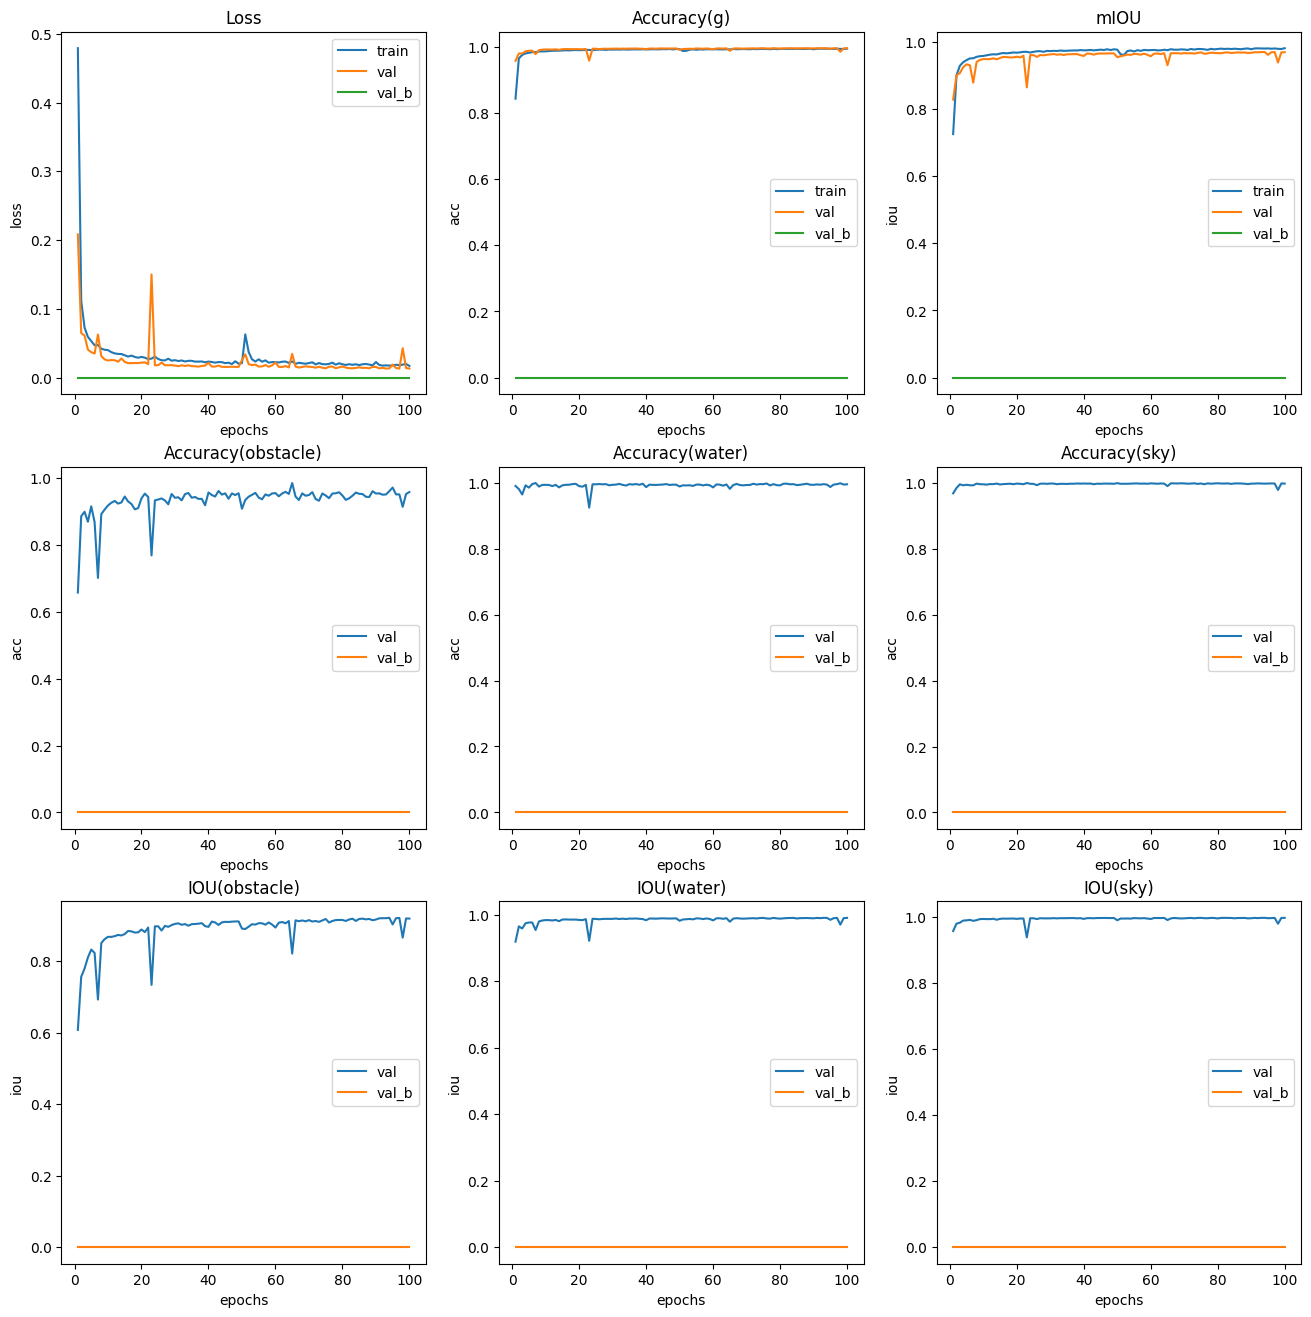

In [ ]:
training_manager.plot()

saving model at 100 epochs...
saving best model at 93 epochs...
saving config...
saving history...
saving png...
Finished saving everything to /content/drive/MyDrive/ShorelineNet_pytorch/results/centralDropout.


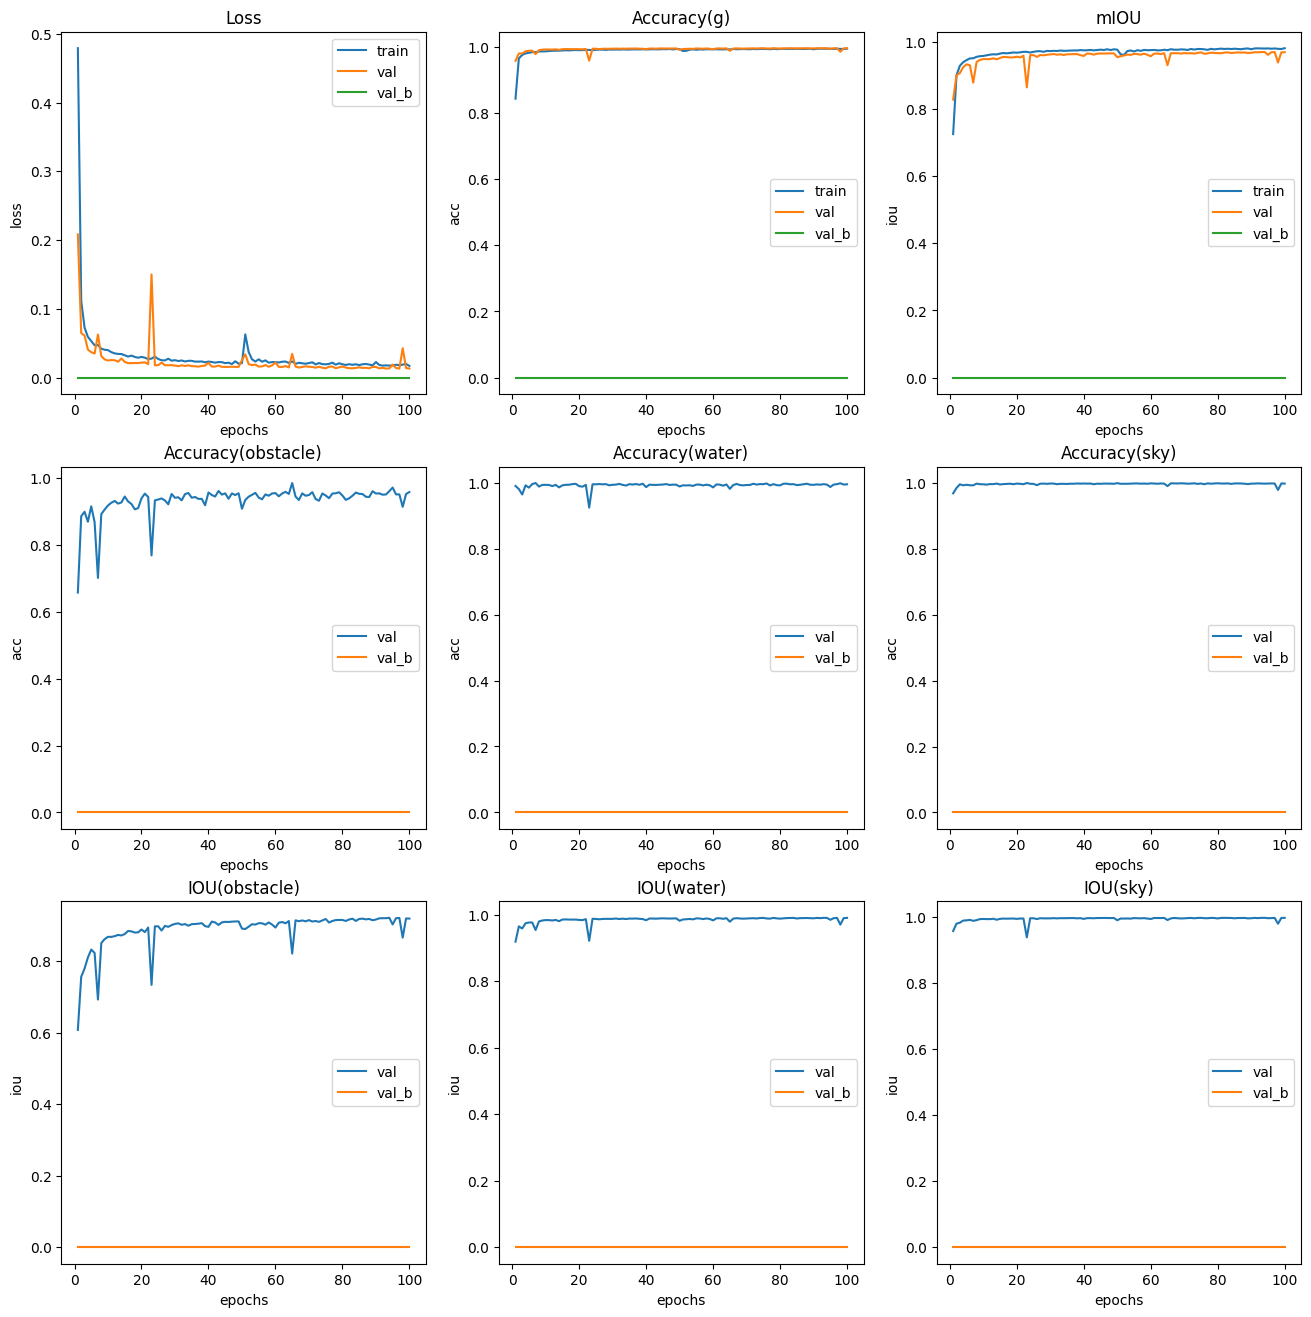

In [ ]:
# saves experiment instance
training_manager.save(EXPERIMENT_DIR, save_plot=True)

In [ ]:
# training_manager.plot_acc_vs_k(save_to_dir=EXPERIMENT_DIR, net=training_manager.best_net)
# training_manager.plot_acc_vs_k(save_to_dir=EXPERIMENT_DIR, net=training_manager.best_net)

## Load trained network

In [ ]:
EXPERIMENT = 'centralDropout'
dummy_config = {
    'batch_size': 20,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : [0, 0, 0, 0.5, 0.5],
    'decoder_dropout_config' : [0.5, 0, 0, 0],
    'patience': 20,
    'loss': 'CE'
}

EXPERIMENT_DIR = os.path.join('/content/drive/MyDrive/ShorelineNet_pytorch/results/', EXPERIMENT)

loaded_manager = TrainingManager(dataset_manager.datasets, dummy_config)
loaded_manager.load(EXPERIMENT_DIR, load_best=True)

loaded_manager.config

Loading config...
Loading network weights...
Loading history...
loaded /content/drive/MyDrive/ShorelineNet_pytorch/results/centralDropout/model_best.pt trained for 200 epochs


{'batch_size': 16,
 'lr': 0.0001,
 'weight_decay': 0.0001,
 'k': 10,
 'encoder_dropout_config': [0, 0, 0.5, 0.5, 0.5],
 'decoder_dropout_config': [0.5, 0.5, 0, 0],
 'patience': 20}

In [ ]:
loaded_manager.evaluate(mode='all')

In [ ]:
# CONTINUE TRAINING
torch.cuda.empty_cache()

RESULT_DIR = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
EXPERIMENT = 'baseline_200e'

EXPERIMENT_DIR = os.path.join(RESULT_DIR, EXPERIMENT)

if EXPERIMENT not in os.listdir(RESULT_DIR):
  os.mkdir(EXPERIMENT_DIR)
else:
  num_items = len(os.listdir(EXPERIMENT_DIR))
  if num_items > 0:
    print('warning: duplicate experiment name!')
    print(f'directory at {EXPERIMENT_DIR} already exists and contains {num_items} items')

In [ ]:
loaded_manager.train(epochs=100, eval_mode='all')

evaluating...


  0%|          | 0/10 [00:00<?, ?it/s]

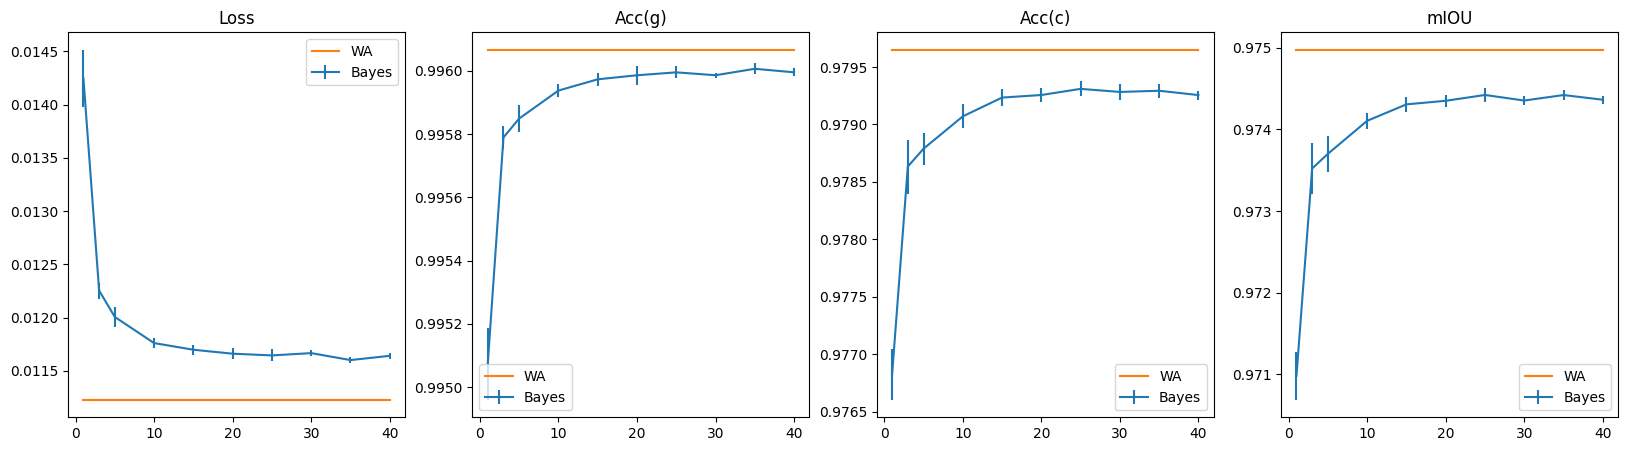

In [ ]:
# loaded_manager.save(EXPERIMENT_DIR, save_plot=True)
loaded_manager.plot_acc_vs_k(num_repeats=5)


## Qualitative performance

In [ ]:
exp = loaded_manager
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 10

for i in range(6):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  plt.imshow(y_std.cpu())
  plt.axis('off')

  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+4)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()

# plt.savefig(os.path.join(EXPERIMENT_DIR, 'qualitative.png'), dpi=200)
# print(f"saved to {os.path.join(EXPERIMENT_DIR, 'qualitative.png')}")

### Per class uncertainty

In [ ]:
exp = loaded_manager
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 20

for i in range(5):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, y_stds, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  if i == 0:
    plt.title(f'{CLASS_MAP[0]}')
  plt.imshow(y_stds[0].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+4)
  if i == 0:
    plt.title(f'{CLASS_MAP[1]}')
  plt.imshow(y_stds[1].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  if i == 0:
    plt.title(f'{CLASS_MAP[2]}')
  plt.imshow(y_stds[2].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  if i == 0:
    plt.title(f'Avg')
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()

# plt.savefig(os.path.join(EXPERIMENT_DIR, 'per_class_uncertainty.png'), dpi=200)
# print(f"saved to {os.path.join(EXPERIMENT_DIR, 'per_class_uncertainty.png')}")

### Epistemic vs Aleatoric Uncertainty

In [ ]:
exp = loaded_manager
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 20

for i in range(6):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  aleatoric, epistemic = compute_bayesian_uncertainties(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  if i == 0:
    plt.title(f'Aleatoric')
  plt.imshow(aleatoric.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+4)
  if i == 0:
    plt.title(f'Epistemic')
  plt.imshow(epistemic.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  if i == 0:
    plt.title(f'Predictive')
  plt.imshow((epistemic + aleatoric).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  if i == 0:
    plt.title(f'Variance')
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()

# plt.savefig(os.path.join(EXPERIMENT_DIR, 'uncertainty_breakdown.png'), dpi=200)
# print(f"saved to {os.path.join(EXPERIMENT_DIR, 'uncertainty_breakdown.png')}")

### Reliability graphs

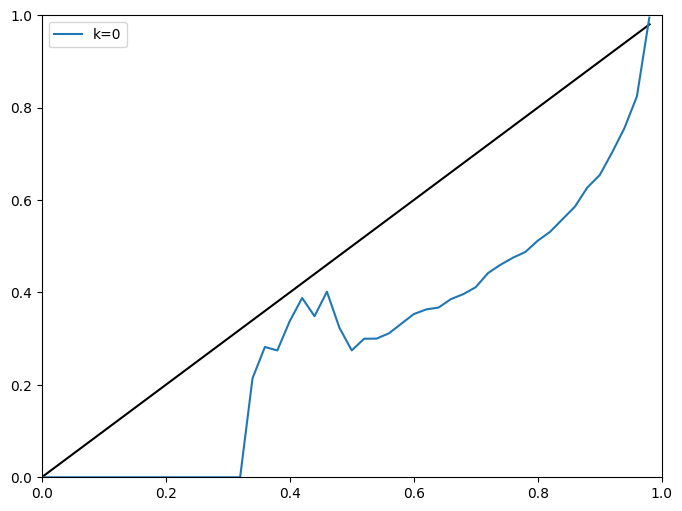

In [ ]:
# plot_calibration(training_manager.net, dataloaders['val'], ks=[0, 10, 30], num_buckets=50, save_to=EXPERIMENT_DIR)
plot_calibration(training_manager.net, dataloaders['val'], ks=[0], num_buckets=50)

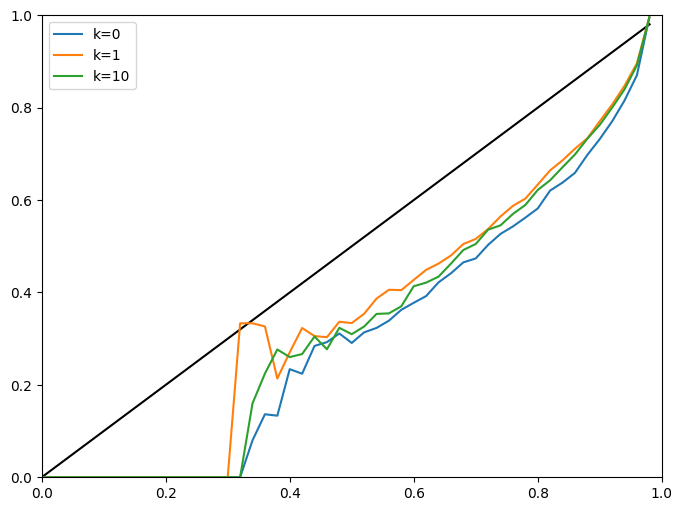

In [ ]:
plot_calibration(loaded_manager.net, dataloaders['val'], ks=[0, 1, 10], num_buckets=50)

## Evaluation

Make predictions on the test set, save the prediction results locally, zip everything & save to google drive

In [ ]:
from torchvision.utils import save_image
from PIL import Image

In [ ]:
# create placeholder folders for predictions
OUT_FOLDER = 'results'

if OUT_FOLDER not in os.listdir():
  os.mkdir(os.path.join('/content', OUT_FOLDER))
  for sequence_folder in os.listdir(TESTING_PATH):
    # print(os.path.join('/content', OUT_FOLDER, sequence_folder))
    os.mkdir(os.path.join('/content', OUT_FOLDER, sequence_folder))
  print(f"created empty folders at {OUT_FOLDER}")


created empty folders at results


In [ ]:
class EvaluationManager():
  def __init__(self, net, test_loader, k=40, out_dir=OUT_FOLDER):
    self.net = net
    self.test_loader = test_loader
    self.k = k
    self.out_dir = out_dir

  def run(self, save=True):
    sequences = os.listdir(self.out_dir)
    print(f'running evaluation on {len(sequences)} sequences')

    buffer = torch.empty((self.k, 3, 224, 224), device=DEVICE)
    count = 0
    for xs, path in tqdm(self.test_loader):
      pred = bayes_eval(self.net, xs, self.k, buffer).to("cpu", torch.uint8).numpy()
      reformatted_pred = self._reformat_image(pred)
      im = Image.fromarray(reformatted_pred)
      resized_im = im.resize((512, 384), Image.NEAREST)
      path = path[0].split('.')[0] + '.png'
      out_path = os.path.join(self.out_dir, path)
      resized_im.save(out_path)

  def _reformat_image(self, arr):
    color_map = {0: [0, 0, 0], 1: [255, 0, 0], 2: [0, 255, 0]}
    rgb_img = np.zeros((*arr.shape, 3), np.uint8)
    for key, value in color_map.items():
      boolean_array = arr == key
      rgb_img[boolean_array] = value

    return rgb_img


In [ ]:
# loop through all the sequences, make predictions, and save results
evaluation_manager = EvaluationManager(loaded_manager.net, test_dataloader, k=40)

In [ ]:
evaluation_manager.run()


running evaluation on 94 sequences


  0%|          | 0/16350 [00:00<?, ?it/s]

### Zip & export to google drive

In [ ]:
EXPERIMENT_NAME = 'MCDropout'
filename = EXPERIMENT_NAME +'.zip'
save_to = '../' + filename

In [ ]:
%%bash
cd results
zip -r '../MCDropout.zip' . -x '.*' -x '__MACOSX'

In [ ]:
# copy the zip file to google drive
if EXPERIMENT_NAME not in os.listdir('/content/drive/MyDrive/ShorelineNet_pytorch/results/'):
  os.mkdir(f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{EXPERIMENT_NAME}/')

target_dir = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{EXPERIMENT_NAME}/'
!cp $filename $target_dir
